In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [2]:
def load_data(round_num: int, type_prefix: str) -> pd.DataFrame:
    """Loads market data efficiently using PyArrow engine.

    Constructs paths relative to the project root to ensure portability
    across different execution environments (notebooks vs scripts).
    """
    # resolve() finds the absolute path to the current working directory
    project_root = Path.cwd().resolve().parent
    file_path = project_root / "data" / f"round{round_num}" / f"combined_{type_prefix}_round_{round_num}.csv"

    if not file_path.exists():
         # Fallback for when running script from root instead of nested folder
        file_path = Path("data") / f"round{round_num}" / f"combined_{type_prefix}_round_{round_num}.csv"

    return pd.read_csv(file_path, sep=';', engine='pyarrow')

In [3]:
prices = load_data(1, "prices")
trades = load_data(1, "trades")

In [4]:
prices.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
1,-2,0,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
2,-2,0,SQUID_INK,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
3,-2,100,KELP,2000,5,1999.0,6.0,1998.0,20.0,2002,20,NaN,NaN,NaN,NaN,2001.0,0.0
4,-2,100,RAINFOREST_RESIN,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0


In [5]:
trades.head()

,day,timestamp,buyer,seller,symbol,currency,price,quantity
0,-2,0,NaN,NaN,KELP,SEASHELLS,2002.0,1
1,-2,0,NaN,NaN,RAINFOREST_RESIN,SEASHELLS,9996.0,1
2,-2,0,NaN,NaN,RAINFOREST_RESIN,SEASHELLS,9996.0,1
3,-2,0,NaN,NaN,SQUID_INK,SEASHELLS,2002.0,1
4,-2,100,NaN,NaN,KELP,SEASHELLS,2002.0,6


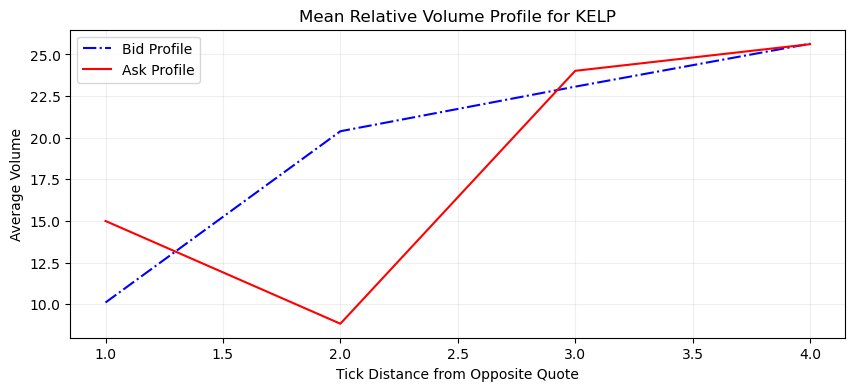

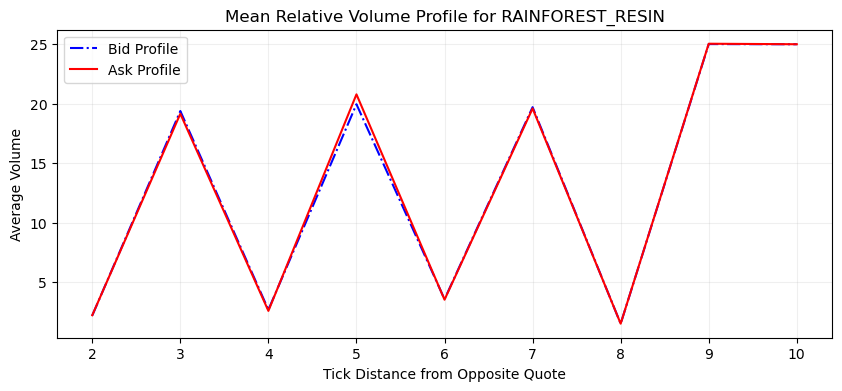

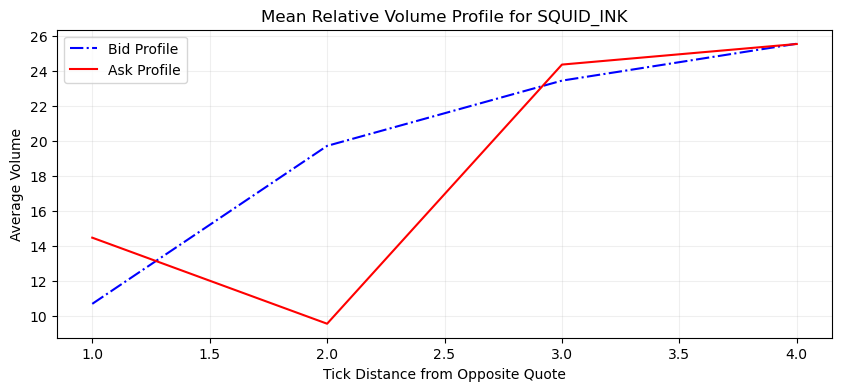

In [ ]:
def plot_relative_profiles(df: pd.DataFrame, prod: str, max_d: int = 10):
    """Aggregates LOB depth into mean relative volume profiles."""
    data = df[df["product"] == prod].copy()
    sides = {"bid": ("ask_price_1", "bid"), "ask": ("bid_price_1", "ask")}
    profiles = {}

    for name, (opp_ref, side) in sides.items():
        levels = []
        for i in range(1, 4):
            # Map absolute prices to tick distance from opposite best quote
            dist = (data[opp_ref] - data[f"{side}_price_{i}"]).abs()
            vol = data[f"{side}_volume_{i}"].fillna(0)
            levels.append(pd.DataFrame({"d": dist, "v": vol}))

        # Compute mean volume per tick distance via vectorized grouping
        profiles[name] = (
            pd.concat(levels).groupby("d")["v"].mean().reindex(range(1, max_d + 1))
        )

    plt.figure(figsize=(10, 4))
    plt.plot(
        profiles["bid"].index,
        profiles["bid"].values,
        "-.",
        color="blue",
        label="Bid Profile",
    )
    plt.plot(
        profiles["ask"].index,
        profiles["ask"].values,
        "-",
        color="red",
        label="Ask Profile",
    )

    plt.title(f"Mean Relative Volume Profile for {prod}")
    plt.xlabel("Tick Distance from Opposite Quote")
    plt.ylabel("Average Volume")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()


# Execution for high resolution regime identification
for asset in prices["product"].unique():
    plot_relative_profiles(prices, asset)